In [1]:
!pip install axelrod

    100% |████████████████████████████████| 92kB 1.0MB/s 
    100% |████████████████████████████████| 71kB 3.3MB/s 
  Running setup.py bdist_wheel for hypothesis ... - \ | done
  Stored in directory: /home/jovyan/.cache/pip/wheels/70/13/1b/ded62e1ad7d6f189c7dd5008a57b7b97e2c92ebf16069cf54e
Successfully built hypothesis
  Found existing installation: pyparsing 2.1.7
    Uninstalling pyparsing-2.1.7:
      Successfully uninstalled pyparsing-2.1.7


In [199]:
!pip install python-ternary

  Running setup.py bdist_wheel for python-ternary ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/bc/65/67/f96aeea8357b58293420e6550387a48c186d53b9af27da4612
Successfully built python-ternary


# Calculating the Fingerprint of a strategy

Assuming I have interpreted [this](http://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=2243&context=rtd) thesis correctly calculating the fingerprint of a strategy can be done as follows:

Play a strategy $S$ against a 'Noisy' strategy $JA$ based on a
strategy $A$

The strategy $JA$ comes from the function $JA(A, x, y)$ where:
   
- $A$ is a strategy
- $x$ is a probability
- $y$ is a probability
   
It behaves in the following fashion:
   
- $JA$ cooperates with probability $x$
- $JA$ defects with probability $y$
- $JA$ behaves like $A$ with probability $1 - (x + y)$

Then the fingerprint of $S$ based on $JA$ is the expected score of $S$ when
played against $JA$ for each $x$, $y$. (This will be a function in $x$ and $y$)
   

### The approach

You can analytically derive the fingerprint function for certain strategies by using the following method:

1. Represent the strategies as finite state machines
2. Construct a Markov Chain of the possible states of the system
3. Find the steady state of the markov chain
   -> This will give the probability distribution of finding the system
      in a state X
4. The expected score is then taking the dot product of these      
   probabilities associated with each state.
   
However it will not always be possible to do this analytically, so a numeric approach will be needed. 

I believe the key to this step is finding the probability distribution we get in step 3. So I propose the following method:

1. Play the two strategies against each other for a large number of turns
   setting a value of $x$ and $y$ in the $JA$ strategy. 
2. Look at the actions taken at the end of each round and count them
3. Normalising this to make all values less than one we will have the PDF
4. Calculate the expected score based on this approximate distribution and
   plot it on the graph
5. Repeat for many values of $x$ and $y$ to build up the graph seen in the 
   link above (Section 2.-1-2.2)

In [124]:
import axelrod as axl
import numpy as np
from axelrod.strategy_transformers import MixedTransformer
import matplotlib.pyplot as plt
import itertools

## Deciding on the Number of Iterations to Run

To get a good approximation of the distribution we need to play a large number of games. This section tries to give us an idea of how many games we need to play to get a good approximation.

In [178]:
def makeplt(players, num_turns):
    
    # Make a match and play it for the number of turns
    match = axl.Match(players, num_turns)
    res = match.play()
    
    # Make the distribution of the states
    keys = [('C','C'), ('C','D'), ('D','C'),('D','D')]
    dist = {k : res.count(k) for k in keys}
    #print(dist)
    
    # Hack it so matplotlib helps us
    vals = [res.count(k) for k in keys]
    vals = list(map(lambda x: x/len(res), vals))
    #print(vals)

    # Return the plot
    return plt.plot([0,1,2,3], vals, label='%i Turns' % num_turns)

In [179]:
prob = [0.4, 0.3]
strats = [axl.Cooperator, axl.Defector]

player = MixedTransformer(prob, strats)(axl.WinStayLoseShift)

#players = (axl.TitForTat(), axl.Defector())
players = (axl.TitForTat(), player())

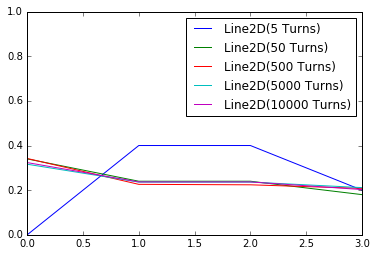

In [180]:
axes = plt.gca()
axes.set_ylim([0, 1.0])

p = makeplt(players, 5)

for n in [50, 500, 5000, 10000]:
    p += makeplt(players, n)
plt.legend(p)

So looking at this it looks like playing for a few thousand turns
should give us a good approximation

## Calculating the Expected Score

Now that we have an idea of the number of runs, we now need to think about how to calculate the expected score for a given $x$ and $y$

The expected score will be given by the sum of the scores multiplied by their probability in the approximated distribution

In [210]:
def calc_expected_score(x, y):
    # Implements the double fingerprint on the unit sqaure 
    if x + y > 1:
        prob = [1 - y, 1 - x]
    else:
        prob = [x, y]
        
    strats = [axl.Cooperator, axl.Defector]

    player = MixedTransformer(prob, strats)(axl.TitForTat)
    players = (axl.WinStayLoseShift(), player())
    scores = [3, 0, 5, 1]
    
    # Make a match and play it for the number of turns
    match = axl.Match(players, 5000)
    res = match.play()
   
    # Make the distribution of the states
    keys = [('C','C'), ('C','D'), ('D','C'),('D','D')]    
    vals = [res.count(k) for k in keys]
    
    # Normalise the distribution
    vals = list(map(lambda x: x/len(res), vals))
    
    # Calculate the expected score
    score = sum(np.multiply(scores, vals))
    
    return score

In [187]:
calc_expected_score(0.2, 0.3)

2.1318000000000001

## Making the plot

Assuming that what we have done here is correct then the plot we get at the end of this section will be the same as the one in the thesis linked above (Figure 2.2)

To make the plot we need to run the above function for many values of $x$ and $y$ and map the expected score we get onto a gradient and plot the colour against the values of $x$ and $y$ we used.

In [ ]:
xs = np.arange(0, 1.0, 0.1)
ys = np.arange(0, 1.0, 0.1)

grid = itertools.product(xs,ys)
#X,Y = np.meshgrid(xs,ys)

vals = [[calc_expected_score(x,y) for y in ys] for x in xs] 

In [ ]:
plt.imshow(vals, interpolation='nearest', cmap='gray') 